 # Сервис аренды самокатов GoFast

Для работы были получены данные сервиса аренды самокатов GoFast.  

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. В нем можно совершать поездки без подписки или с подпиской:  
1.без подписки  
  * абонентская плата отсутствует;  
  * стоимость одной минуты поездки — 8 рублей;  
  * стоимость старта (начала поездки) — 50 рублей;  
  
2.с подпиской Ultra  
  * абонентская плата — 199 рублей в месяц;  
  * стоимость одной минуты поездки — 6 рублей;  
  * стоимость старта — бесплатно.  
  
Первым этапом посмотрим общую информацию датафреймов с данным о пользователях, подписках и поездках. Далее проверим наличие дублей, пропущенных значений и соответствие типа данных информации в столбцах.  

Визуализируем информацию о городах, доле пользователей с подпиской и без нее, возраст пользователей, а так же длительность и расстояние поздок.  

Посмотрим, какое расстояние за месяц проезжает каждый пользователь и сколько выручки получает компания. 

Так же будет проверен ряд гипотез.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import poisson
from math import factorial, exp

#### Шаг 1. Загрузка данных

In [2]:
try:
    data_users = pd.read_csv('/datasets/users_go.csv')
    data_rides = pd.read_csv('/datasets/rides_go.csv')
    data_subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    data_rides = pd.read_csv('https://code.s3.yandex.net//datasets/rides_go.csv')
    data_subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

**Посмотрим данные датафрейма "Пользователи"**

In [3]:
display(data_users.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датафрейме есть 5 столбцов со следующей информацией:  
user_id - уникальный идентификатор пользователя  
name - имя пользователя  
age - возраст  
city - город  
subscription_type - тип подписки (free, ultra)  

**Посмотрим данные датафрейма "Поездки"**

In [5]:
display(data_rides.head())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Значения расстояния поездок округлим для удобства.

In [50]:
data_rides['distance'] = data_rides['distance'].round(0)
display(data_rides.head())

,user_id,distance,duration,date,month
0,1,4410.0,25.599769,2021-01-01,1
1,1,2618.0,15.816871,2021-01-18,1
2,1,754.0,6.232113,2021-04-20,4
3,1,2695.0,18.511000,2021-08-11,8
4,1,4029.0,26.265803,2021-08-28,8


In [6]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


user_id - уникальный идентификатор пользователя  
distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)  
duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
date - дата совершения поездки  

**Посмотрим данные датафрейма "Подписки"**

In [7]:
display(data_subs.head())

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


subscription_type - тип подписки  
minute_price - стоимость одной минуты поездки по данной подписке  
start_ride_price - стоимость начала поездки  
subscription_fee - стоимость ежемесячного платежа  

#### Шаг 2. Предобработка данных

**2.1 Скорректируем тип данных.**  
В столбце с датой поездки был некорректный тип данных. Исправим на корректный.

In [9]:
data_rides['date'] = pd.to_datetime(data_rides['date'])

In [10]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


**2.2 Создадим столбец с номером месяца.**  
Для удобства фильтрации и анализа посмотрим период, за который получены данные и создадим столбец с номером месяца от 1 до 12.

In [48]:
min_date = data_rides['date'].min()
max_date = data_rides['date'].max()
print(f"Самая ранняя дата поездки: {min_date.strftime('%Y-%m-%d')}")
print(f"Самая поздняя дата поездки: {max_date.strftime('%Y-%m-%d')}")

Самая ранняя дата поездки: 2021-01-01
Самая поздняя дата поездки: 2021-12-30


In [11]:
data_rides['month'] = data_rides['date'].dt.month
display(data_rides)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


**2.3 Проверим наличие пропущенных значений и дубликатов в датафреймах.**

**Пользователи.**

In [12]:
print(data_users.isnull().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


In [13]:
duplicates = data_users.duplicated()
display(duplicates.sum())

31

In [14]:
users_duplicates = data_users.drop_duplicates()
display(users_duplicates)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


В датафрейме с информацией о пользователях нет пропущенных значений, но есть 31 дубликат. Они были удалены.

**Поездки.**

In [15]:
print(data_rides.isnull().sum())

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64


In [16]:
duplicates = data_rides.duplicated()
display(duplicates.sum())

0

В датафрейме с информацией о поездках нет пропущенных значений или дубликатов.

**Подписки.**

In [17]:
print(data_subs.isnull().sum())

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [18]:
duplicates = data_subs.duplicated()
display(duplicates.sum())

0

В датафрейме с информацией о подписках нет пропущенных значений или дубликатов.

Во время подготовки выяснено, что для анализа были получены данные пользователей аренды самокатов за 2021 год из нескольких городов России.  
В данных нет пропущенных значений, но был 31 дубликат, которые удалены.  
Для дальнейшего анализа есть данные о городе, возврасте, уникальном id пользователя. Данные о стоимости поездки и подписки. А так же дата поездки, ее расстояние и время.

#### Шаг 3. Исследовательский анализ данных

**3.1 Частота встречаемости городов.**

In [19]:
users_city = data_users.pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
users_city = users_city.sort_values(by='user_id', ascending = True)
display(users_city.sort_values(by='user_id', ascending = False))

,user_id
city,
Пятигорск,226
Екатеринбург,206
Ростов-на-Дону,202
Краснодар,196
Сочи,192
Омск,186
Тюмень,185
Москва,172


Посмотрим график.

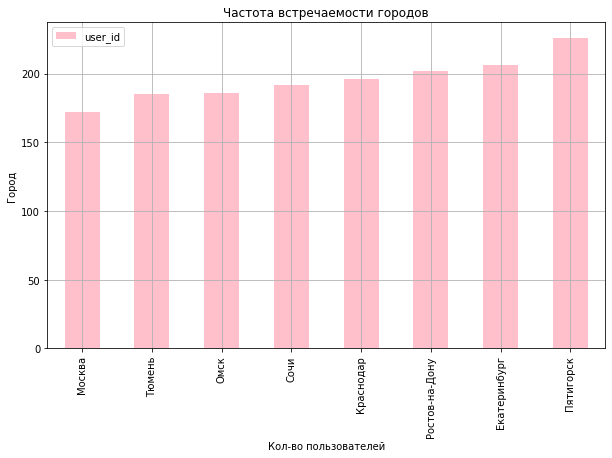

In [20]:
users_city.plot(kind='bar', figsize = (10, 6), grid = True, color = 'pink')
plt.title('Частота встречаемости городов')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Город')
plt.show()

Больше всего пользователей аренды самокатов GoFast в городе Пятигорск.  
Наименее популярен сервис в Москве.

**3.2 Соотношение пользователей с подпиской и без подписки.**

In [23]:
users_subs = data_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count').reset_index()
users_subs['percentage'] = users_subs['user_id'] / users_subs['user_id'].sum() * 100

display(users_subs)

,subscription_type,user_id,percentage
0,free,846,54.057508
1,ultra,719,45.942492


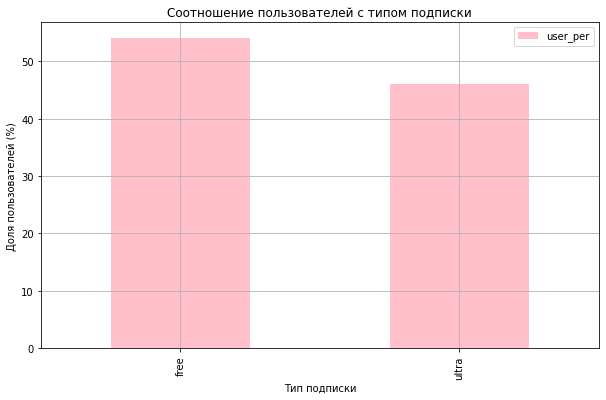

In [24]:
subs_totals = users_subs['user_id'].sum()
users_subs['user_per'] = (users_subs['user_id'] / subs_totals) * 100

users_subs.plot(x='subscription_type', y='user_per', grid=True, kind='bar', figsize=(10, 6), color='pink')
plt.title('Соотношение пользователей с типом подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Доля пользователей (%)')
plt.show()

Пользователей без подписки больше примерно на 8 процентов.

**3.3 Возраст пользователей.**

In [25]:
data_users['age'].describe()

count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

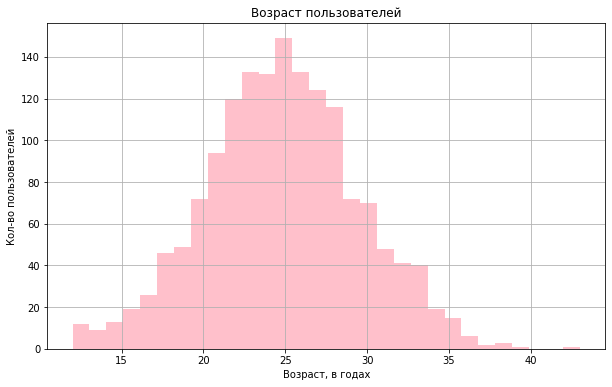

In [26]:
data_users['age'].plot(kind = 'hist', grid=True, figsize = (10, 6), bins = 30, color = 'pink')
plt.title('Возраст пользователей')
plt.xlabel('Возраст, в годах')
plt.ylabel('Кол-во пользователей')
plt.show()

Самые активные пользователи аренды самокатов в возврате от 22 до 27 лет.  
Наименьший интерес к сервису у пользователей старше 35 лет.  

**3.4 Расстояние, которое пользователь преодолел за одну поездку.**

In [27]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

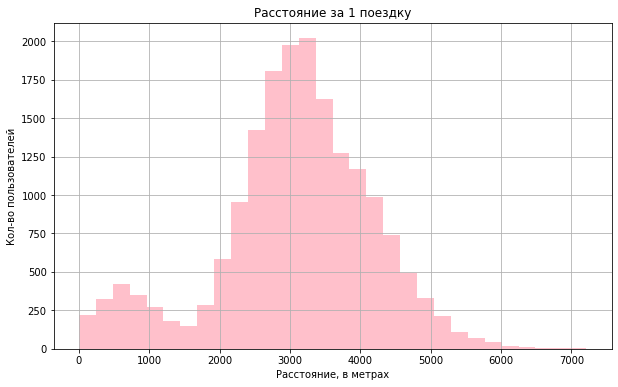

In [28]:
data_rides['distance'].plot(kind = 'hist', grid=True, figsize = (10, 6), bins = 30, color = 'pink')
plt.title('Расстояние за 1 поездку')
plt.xlabel('Расстояние, в метрах')
plt.ylabel('Кол-во пользователей')
plt.show()

Как правило, поездка занимает от 2 до 4 километров, в среднем 3 километра. За пределами этого интервала поездок в разы меньше.  
Но некоторой популярностью пользуются поездки до 1 километра. Может быть это поездки до ближайшей станции метро или какая-либо техническая причина, по которой поездка была недолгой.

**3.5 Продолжительность поездок.**

In [29]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

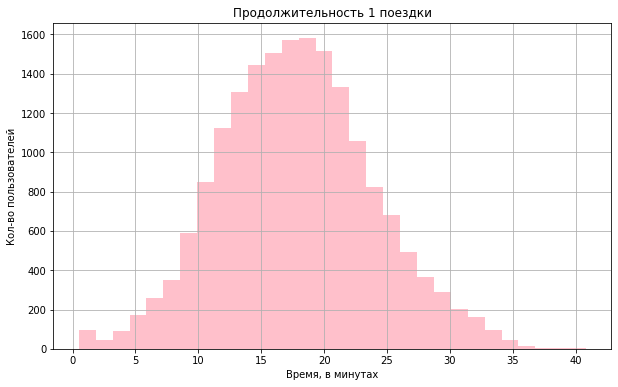

In [30]:
data_rides['duration'].plot(kind = 'hist', grid=True, figsize = (10, 6), bins = 30, color = 'pink')
plt.title('Продолжительность 1 поездки')
plt.xlabel('Время, в минутах')
plt.ylabel('Кол-во пользователей')
plt.show()

Чаще всего поездка занимает от 15 до 20 минут.  
Есть поездка менее минуты. Возможно, после начала аренды была обнаржена неисправность самоката. 

#### Шаг 4. Объединение данных

**4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм.**

In [31]:
data_all = data_rides.merge(data_users, on = 'user_id', how = 'left')
data_all = data_all.merge(data_subs, on='subscription_type', how = 'left')
display(data_all)
data_all.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18383,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18384,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18385,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18386,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18388 entries, 0 to 18387
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   distance           18388 non-null  float64       
 2   duration           18388 non-null  float64       
 3   date               18388 non-null  datetime64[ns]
 4   month              18388 non-null  int64         
 5   name               18388 non-null  object        
 6   age                18388 non-null  int64         
 7   city               18388 non-null  object        
 8   subscription_type  18388 non-null  object        
 9   minute_price       18388 non-null  int64         
 10  start_ride_price   18388 non-null  int64         
 11  subscription_fee   18388 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Датафреймы с информацией и пользователях и поездках объеденили по столбцу user_id. А потом объеденили с датареймом о подписках по столбцу subscription_type.

**4.2 Создадим новый датафрейм - c данными о пользователях без подписки.**

In [32]:
data_without_subs = data_all[data_all['subscription_type'] == 'free']
display(data_without_subs)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6672,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6673,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6674,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6675,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6676,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18383,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18384,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18385,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18386,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


**4.2.1 Создадим новый датафрейм - c данными о пользователях с подпиской.**

In [33]:
data_with_subs = data_all[data_all['subscription_type'] == 'ultra']
display(data_with_subs)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6667,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6668,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6669,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6670,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


**4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.**

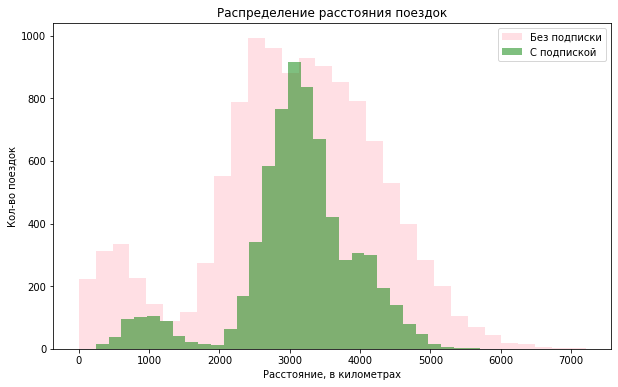

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(data_without_subs['distance'], bins=30, alpha=0.5, color='pink', label='Без подписки')

plt.hist(data_with_subs['distance'], bins=30, alpha=0.5, color='green', label='С подпиской')

plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние, в километрах')
plt.ylabel('Кол-во поездок')
plt.legend()
plt.show()

Пользователи без подписки предпочитают поездки до 1 километра, либо от 2 до 4,5 километров.  
Пользователи с подпиской чаще всего проезжают около 3 километров.

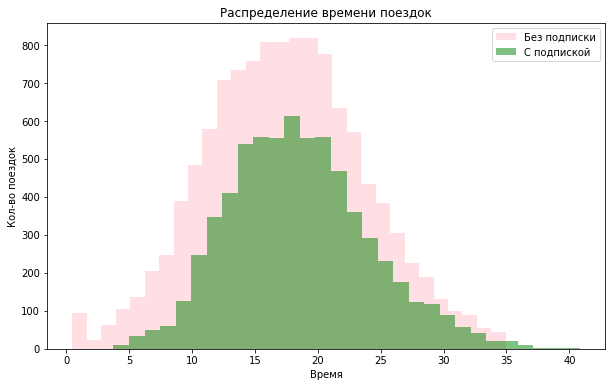

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(data_without_subs['duration'], bins=30, alpha=0.5, color='pink', label='Без подписки')

plt.hist(data_with_subs['duration'], bins=30, alpha=0.5, color='green', label='С подпиской')

plt.title('Распределение времени поездок')
plt.xlabel('Время')
plt.ylabel('Кол-во поездок')
plt.legend()
plt.show()

Пользователей без подписки больше, чем тех, кто подписку оформил. При этом обе категории предпочитают поездки по 15-20 минут.

#### Шаг 5. Подсчёт выручки

**5.1** Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [36]:
data_all['duration'] = np.ceil(data_all['duration'])
data_all['duration'] = data_all['duration'].astype('int')

agg_data = data_all.pivot_table(index= ['user_id', 'month'], 
                                values = ['distance', 'duration'], aggfunc = ['count', 'sum']).reset_index()

agg_data.columns = ['user_id', 'month', 'count_distance', 'sum_distance', 'count_duration', 'sum_duration']
agg_data = agg_data.drop(columns=['count_distance']) #удаляем, так как столбец неинформативен.
display(agg_data)

,user_id,month,sum_distance,count_duration,sum_duration
0,1,1,2,7027.511294,42
1,1,4,1,754.159807,7
2,1,8,2,6723.470560,46
3,1,10,2,5809.911100,32
4,1,11,3,7003.499363,56
...,...,...,...,...,...
11326,1534,6,2,3409.468534,26
11327,1534,8,2,7622.453034,48
11328,1534,9,1,4928.173852,23
11329,1534,11,4,13350.015305,78


Теперь можно посмотреть:  
1. sum_distance - расстояние за месяц.  
2. count_duration - количество поездок за месяц.  
3. sum_duration - количество минут за месяц.

**5.2** В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [37]:
data_all.drop_duplicates(subset=['user_id', 'month'], keep='first', inplace=True)
agg_data = pd.merge(agg_data, data_all[['user_id', 'month', 'subscription_type', 'subscription_fee']], 
                    on=['user_id', 'month'], how='left')

agg_data['monthly_revenue'] = np.where(
    agg_data['subscription_type'] == 'ultra',agg_data['sum_duration'] * 6 + 199,
    agg_data['sum_duration'] * 8 + 50 + agg_data['subscription_fee'])

agg_data.drop('subscription_type', axis=1, inplace=True)

display(agg_data)

,user_id,month,sum_distance,count_duration,sum_duration,subscription_fee,monthly_revenue
0,1,1,2,7027.511294,42,199,451
1,1,4,1,754.159807,7,199,241
2,1,8,2,6723.470560,46,199,475
3,1,10,2,5809.911100,32,199,391
4,1,11,3,7003.499363,56,199,535
...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26,0,258
11327,1534,8,2,7622.453034,48,0,434
11328,1534,9,1,4928.173852,23,0,234
11329,1534,11,4,13350.015305,78,0,674


#### Шаг 6. Проверка гипотез

**6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используя исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.**  

Нулевая гипотеза: среднее время поездок пользователей не зависит от наличия подписки и являются равными.  
Альтернативная гипотеза: с подпиской время поездки больше.

Для начала посчитаем средние значения времени поездки.

In [38]:
print('С подпиской:', round(data_with_subs['duration'].mean(),2))
print('Без подписки:', round(data_without_subs['duration'].mean(),2))

С подпиской: 18.53
Без подписки: 17.39


In [39]:
alpha = 0.05
results = st.ttest_ind(data_with_subs['duration'], data_without_subs['duration'], alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.6261032773552045e-34
Отвергаем нулевую гипотезу


Среднее время не на много, но отличается, поэтому нулевую гипотезу отвергаем.

**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим, можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**  

Нулевая гипотеза: среднее расстояние поездки с подпиской - 3130 метров.  
Альтернативная гипотеза: подписчики в среднем проезжают расстояние больше оптимального.

In [40]:
print('Среднее расстояние поездки c подпиской:', round(data_with_subs['distance'].mean()))

Среднее расстояние поездки c подпиской: 3115


In [44]:
mean_dist = 3130
alpha = 0.05
results = st.ttest_1samp(data_with_subs['distance'], mean_dist, alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Недостаточно доказательств, чтобы обвергнуть нулевую гипотезу')

p-значение: 0.9224525735508029
Недостаточно доказательств, чтобы обвергнуть нулевую гипотезу


Нулевую гипотезу не отвергаем.  
Среднее расстояние поездки равняется 3115 метрам.


**6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**  

Нулевая гипотеза: пользователи с подпиской и без нее приносят одинаковую ежемесячную выручку.  
Альтернативная гипотеза: пользователи с подпиской ежемесячно приносят боольше выручку, чем пользователи без подписки.

In [42]:
ave_rev_with_subs = agg_data[agg_data['subscription_fee'] == 199]['monthly_revenue'].mean()
ave_rev_without_subs = agg_data[agg_data['subscription_fee'] == 0]['monthly_revenue'].mean()

print('Средняя выручка с подпиской:', round(ave_rev_with_subs, 2))
print('Средняя выручка без подписки:', round(ave_rev_without_subs, 2))

Средняя выручка с подпиской: 367.03
Средняя выручка без подписки: 296.72


In [43]:
alpha = 0.05

with_subs_data = agg_data[agg_data['subscription_fee'] == 199]['monthly_revenue']
without_subs_data = agg_data[agg_data['subscription_fee'] == 0]['monthly_revenue']

results = st.ttest_ind(with_subs_data, without_subs_data, alternative='greater')
print('p-значение:', results.pvalue)


if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 5.295040937376663e-171
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергаем. Пользователи с подпиской приносят больше выручки, чем пользователи без подписки.

**6.4 Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.**

Для проверки этой гипотезы нам понадобится t-тест для связанных (парных) выборок. С этим тестом достаточно передать всего два параметра: наборы данных до и после. 
Парная выборка означает, что некоторая переменная измеряется дважды для одних и тех же объектов. В нашем примере это пара измерений для каждого пользователя — до и после обновления сервера.  


#### Шаг 7. Выводы

На основании проведенного анализа можно сделать выводы:  
1. В тройку самых активных пользователей аренды самокатов GoFast входят жители Пятигорска, Екатеринбурга и Ростова-на-Дону.  
2. Количество пользователей без подписки обгоняет на 8% количество пользователей с подпиской.  
3. Самые активные пользователи самокатов в возврасте от 22 до 27 лет.  
4. В среднем поездка длится 15-20 минут. За это время пользователи проезжают около 3 километров. Такую статистику показали пользователи и с подпиской и без нее.   
5. Проверили ряд гипотез:
  * отвергли нулевую гипотезу, о том что среднее время поездок пользователей не зависит от наличия подписки и являются равными.  
  * недостаточно доказательств, чтобы отвергнуть нулевую гипотезу, что среднее расстояние поездки с подпиской - 3130 метров.  
  * отвергли нулевую гипотезу, что пользователи с подпиской и без нее приносят одинаковую ежемесячную выручку.  